In [ ]:
# Installations
%pip install "git+https://github.com/tournesol-app/tournesol.git@solidago-pipeline#egg=solidago&subdirectory=solidago"

In [45]:
# Imports
import networkx as nx
import matplotlib.pyplot as plt
import math
import csv
import time
import colorsys
import warnings

from solidago.pipeline.inputs import TournesolInputFromPublicDataset

In [47]:
PUBLIC_DATASET = TournesolInputFromPublicDataset.download()

In [48]:
USER_TO_PLOT = 'NatNgs'
TIME_TO_RUN = 120 # Seconds, the longer the prettier (but the more time it will take to compute)

In [54]:
user_comparisons = PUBLIC_DATASET.comparisons[PUBLIC_DATASET.comparisons.public_username == USER_TO_PLOT]\
                                             [PUBLIC_DATASET.comparisons.criteria == 'largely_recommended']\
                                             [['entity_a', 'entity_b']]
user_comparisons_list = zip(user_comparisons['entity_a'], user_comparisons['entity_b'])

graph = nx.Graph()
graph.add_edges_from(user_comparisons_list)
largest_group = max(nx.connected_components(graph), key=len)
graph.remove_nodes_from(n for n in list(graph.nodes) if not n in largest_group)
print('Loaded', graph)

Loaded Graph with 696 nodes and 1666 edges


In [51]:
## Preparing Graph Layout
start = time.time()

# Initialy put all nodes in a circle around the center
pos=nx.circular_layout(graph)

iterations_count=10
total_iterations=0
timer_a = time.time()
loops_count = 0
while timer_a - start < TIME_TO_RUN:
	loops_count += 1
	# Move nodes towards eachother if connected, move them apart from eachother if not connected
	pos = nx.spring_layout(graph, pos=pos, weight='spring', iterations=iterations_count)
	total_iterations += iterations_count
	timer_b = time.time()
	speed = iterations_count / (timer_b-timer_a)
	expected_remaining_iterations = speed * (TIME_TO_RUN - timer_b + start)
	print(f"Iterations: {total_iterations}/{total_iterations + expected_remaining_iterations:.0f} -- Time: {timer_b-start:.1f}/{TIME_TO_RUN}s -- Speed: {speed:.1f}/s")
	next_iteration_count = int(math.ceil(expected_remaining_iterations / (10 - loops_count if loops_count < 10 else 1)))
	if next_iteration_count > iterations_count*2 and loops_count > 1:
		# Spring Layout may stop iterating if found an equilibrium. Try to detect this event and stop before max_duration
		break
	# Prepare next iteration
	iterations_count = next_iteration_count
	timer_a = timer_b

end = time.time()
print()

Iterations: 10/1831 -- Time: 0.7/120s -- Speed: 15.3/s
Iterations: 213/2613 -- Time: 10.0/120s -- Speed: 21.8/s
Iterations: 514/2618 -- Time: 23.7/120s -- Speed: 21.9/s
Iterations: 815/2608 -- Time: 37.6/120s -- Speed: 21.8/s
Iterations: 1114/2602 -- Time: 51.4/120s -- Speed: 21.7/s
Iterations: 1412/2622 -- Time: 64.9/120s -- Speed: 22.0/s
Iterations: 1715/2614 -- Time: 78.8/120s -- Speed: 21.8/s
Iterations: 2015/2615 -- Time: 92.5/120s -- Speed: 21.8/s
Iterations: 2315/2614 -- Time: 106.3/120s -- Speed: 21.8/s
Iterations: 2614/2614 -- Time: 120.0/120s -- Speed: 21.8/s



min & max colors: 1 11
Image size: 8.2x6.1


<Figure size 640x480 with 0 Axes>

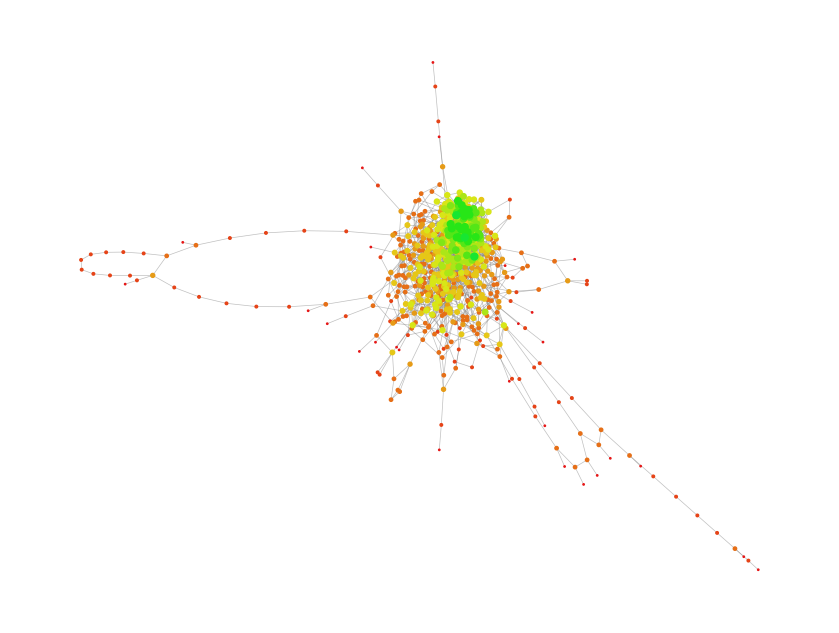

In [52]:
# Order nodes by color
colors_map = {n: len(graph[n]) for n in graph.nodes}
nodes = sorted(graph.nodes, key=colors_map.get)
sorted_graph = nx.Graph()
sorted_graph.add_nodes_from(nodes)
sorted_graph.add_edges_from(graph.edges.data())

# node color
min_c = min(colors_map.values())
mm_c = max(colors_map.values()) - min_c
print('min & max colors:', min_c, min_c + mm_c)

# Make colors from red(min) to green(max)
colors = [colorsys.hsv_to_rgb((colors_map[n]-min_c)/mm_c * (128/360), .9, .9) for n in nodes]

# Prepare image
plt.box(False)
plt.clf()
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.rc('axes', unicode_minus=False)

# Output svg dimensions
size = (sorted_graph.number_of_nodes()+1)**0.25
print(f"Image size: {size*1.4+1:.1f}x{size+1:.1f}")
fig = plt.figure(figsize=(size*1.4+1, size+1), frameon=False)

# Axis
fig.clear()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.set_facecolor('#FFF') # Background color

nodes_width = {n:d for n,d in graph.degree}
min_w = min(nodes_width.values())
mm_w = max(nodes_width.values()) - min_w
min_display = 1
mm_display = 25 - min_display
nx.draw_networkx_nodes(sorted_graph,
	pos=pos,
	nodelist=nodes,
	node_size=[min_display+mm_display*(nodes_width[n]-min_w)/mm_w for n in nodes],
	node_color=colors
)

nx.draw_networkx_edges(sorted_graph,
	pos=pos,
	edge_color='#8888',
	width=0.5,
)

warnings.filterwarnings("ignore", category=UserWarning)